In [13]:
import numpy as np 
import pandas as pd 

import scipy.optimize

import altair as alt 

import bootcamp_utils

In [3]:
df = pd.read_csv('~/git/Bootcamp/data/bcd_gradient.csv', comment="#")

In [7]:
df = df.rename(columns={'[bcd] (a.u.)': 'bcd'})
df.head()

,fractional distance from anterior,bcd
0,0.002645,0.863097
1,0.034223,0.863097
2,0.068446,0.745727
3,0.102629,0.654875
4,0.134207,0.545114


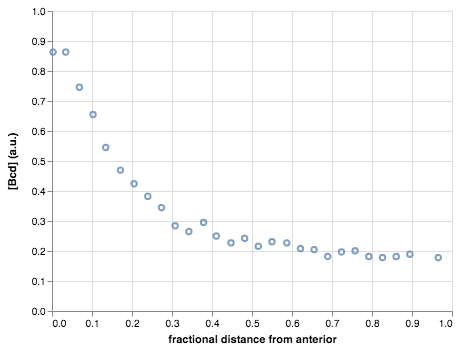

In [9]:
dots = alt.Chart(df
                ).mark_point(
                ).encode(
                    x='fractional distance from anterior:Q',
                    y=alt.Y('bcd:Q', title='[Bcd] (a.u.)', scale=alt.Scale(domain=[0, 1])))
dots

In [31]:
def bcd_gradient_model_first_try(x, I_0, a, lam):
    """Model for Bcd gradient: exponential decay plus background"""
    return a + I_0 * np.exp(-x/lam)


def bcd_gradient_model(x, I_0, a, lam):
    if np.any(x < 0):
        raise RuntimeError("All values of 'x' must be >= 0.")
    if np.any(np.array([I_0, a, lam]) < 0):
        raise RuntimeError('All parameters must be >= 0.')
    return a + I_0 * np.exp(-x/lam)

In [32]:
#specify initial guesses 

I_0_guess = 0.7
a_guess = 0.2 
lam_guess = 1.0 

p0 = np.array([I_0_guess, a_guess, lam_guess])

In [33]:
p, _ = scipy.optimize.curve_fit(bcd_gradient_model_first_try,
                                df['fractional distance from anterior'],
                                df['bcd'],
                                p0=p0)

In [23]:
p

array([0.76762162, 0.17423312, 0.18712895])

In [35]:
def bcd_gradient_model_log_params(x, log_I_0, log_a, log_lam):
    #exponentiate the parameters
    I_0, a, lam = np.exp(np.array([log_I_0, log_a, log_lam]))
    return bcd_gradient_model(x, I_0, a, lam)

In [37]:
log_p0 = np.log(p0)

In [38]:
log_p, _ = scipy.optimize.curve_fit(bcd_gradient_model_log_params, 
                                   df['fractional distance from anterior'], 
                                   df['bcd'],
                                   p0 = log_p0)
p = np.exp(log_p)

p

array([0.76762142, 0.17423289, 0.18712931])

In [48]:
df = pd.read_csv('grant_complete.csv', comment='#')   
df = df.loc[(df['year']==1987) & (df['species']=='scandens'), :]
#df = df.drop_duplicates(subset=['band'])
#df = df[['beak length (mm)', 'beak depth (mm)'']]   
df.head()

,band,beak depth (mm),beak length (mm),species,year
1275,15718,7.77,10.75,scandens,1987
1276,5594,7.94,13.73,scandens,1987
1277,15235,7.96,14.04,scandens,1987
1278,15252,8.00,12.50,scandens,1987
1279,15847,8.01,12.64,scandens,1987


In [51]:
dots = alt.Chart(df
                ).mark_point(
                ).encode(
                    alt.X('beak length (mm):Q', scale=alt.Scale(zero=False)),
                    alt.Y('beak depth (mm):Q', scale=alt.Scale(zero=False)),
)

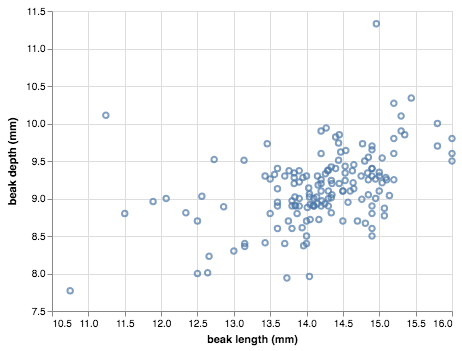

In [52]:
dots

In [61]:
beak_length = df['beak length (mm)'].values 
beak_depth = df['beak depth (mm)'].values
slope, intercept = np.polyfit(beak_length, beak_depth, deg=1)
x = np.array([10.5, 16.5])
y = slope * x + intercept
df_line = pd.DataFrame({'x':x, 'y':y})

In [62]:
reg_line = alt.Chart(df_line
                    ).mark_line(
                        size=3, 
                        color='orange'
                    ).encode(
                        x=alt.X('x:Q', 
                               scale=alt.Scale(zero=False)), 
                        y=alt.Y('y:Q', 
                               scale=alt.Scale(zero=False))

)

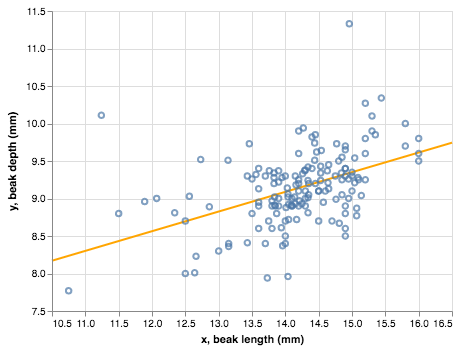

In [63]:
reg_line + dots

In [64]:
def draw_bs_pairs_linreg(x, y, size=1):
    inds = np.arange(len(x))
    
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope, bs_intercept = np.polyfit(bs_x, bs_y, deg=1)
        
        bs_slope_reps[i], bs_intercept_reps[i] = bs_slope, bs_intercept
        
        return bs_slope_reps, bs_intercept_reps

In [65]:
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(beak_length, beak_depth, size=10000)

In [67]:
slope, np.percentile(bs_slope_reps, [2.5, 97.5])

(0.2622588850499042, array([0.00000000e+000, 4.47450698e-313]))

In [68]:
# x-values
x = np.linspace(10.5, 16.5, 200)

# y-values of each point
y = np.outer(bs_slope_reps, x) + np.stack([bs_intercept_reps]*200, axis=1)

# Compute the 2.5th and 97.5th percentiles
low, high = np.percentile(y, [2.5, 97.5], axis=0)

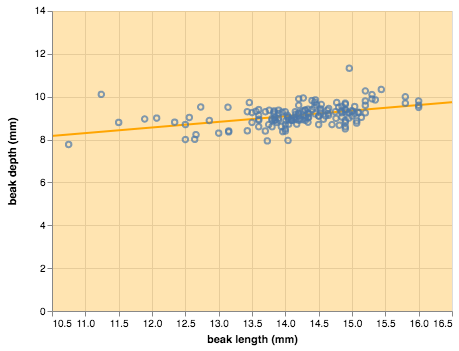

In [69]:
df_conf = pd.DataFrame({'x': x, 'high': high, 'low': low})

conf = alt.Chart(df_conf
    ).mark_area(
        color='orange',
        opacity=0.3
    ).encode(
        x=alt.X('x:Q', title='beak length (mm)', scale=alt.Scale(zero=False)),
        y=alt.Y('low:Q', title='beak depth (mm)', scale=alt.Scale(zero=False)),
        y2=alt.Y2('high:Q')
    )

conf + reg_line + dots